<a href="https://colab.research.google.com/github/22Himanshu/Modified-Coals-Algorithm-word-to-dense-vectors/blob/main/Modified_Coals_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Himanshu

# MDS202328

In [ ]:
from multiprocessing import Pool, cpu_count
from collections import Counter
import numpy as np
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
import random
import warnings
warnings.filterwarnings('ignore')
random.seed(42)
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
processed_text_path = '/content/drive/My Drive/Colab Notebooks/processed_corpus.txt'

In [ ]:
with open(processed_text_path, 'r', encoding = 'utf-8') as file:
  content = file.read()

### Steps to Create a Co-occurrence Matrix

1. **Load Data**
   - Load processesed file from previous assignment

2. **Initialize Co-occurrence Matrix**
   - **Prepare Matrix:**
     - Initialize a numpy 7000*7000 matrix for storing co-occurrence counts based on the global vocabulary.

3. **Process parallely**
   - **Load Data:**
     - Separate data into chunks and feed 1 chunk to 1 worker for parallel processing
   - **Update Matrix:**
     - Convert tokens to matrix indices using the global vocabulary.
     - Update the co-occurrence matrix based on token co-occurrences within a defined window size.

Text tokenizer

In [ ]:
def data_loader(content):
  tokens = content.split()
  dim = 7000
  most_freq = {word for word, _ in Counter(tokens).most_common(dim)}
  token_to_index = {token: idx for idx, token in enumerate(most_freq)}
  return tokens , token_to_index

### Creating count cooccurrence matrix

In [ ]:
def cooccurrence_in_chunks(corpus, vocab, window_size, num_workers=cpu_count()):
    # Split corpus into chunks for parallel processing
    chunk_size = len(corpus) // num_workers
    chunks = [corpus[i-2:i + chunk_size + 2] for i in range(2, len(corpus), chunk_size)]

    # Preparing data to be sent to each worker
    chunk_data = [(chunk, vocab, window_size) for chunk in chunks]

    with Pool(num_workers) as pool:
        results = pool.map(cooccurrence_matrix_solver, chunk_data)

    # Sum the results from each chunk to get the final matrix
    final_matrix = np.sum(results, axis=0)
    return final_matrix

def cooccurrence_matrix_solver(chunk_data):
    chunk, vocab, window_size = chunk_data
    vocab_size = len(vocab)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=int)

    chunk_length = len(chunk)
    for i, word in enumerate(chunk):
        if word in vocab:
            word_idx = vocab[word]
            start = max(0, i - window_size)
            end = min(chunk_length, i + window_size + 1)
            for j in range(start, end):
                if i != j and chunk[j] in vocab:
                    context_idx = vocab[chunk[j]]
                    distance = abs(i-j)
                    weight = window_size + 1 - distance
                    co_matrix[word_idx, context_idx] += weight
    return co_matrix

def create_cooccurrence_matrix(content):
  tokens , token_to_index = data_loader(content)
  co_matrix = cooccurrence_in_chunks(tokens,token_to_index,4)
  return co_matrix
cooccurrence_matrix = create_cooccurrence_matrix(content)
print(cooccurrence_matrix.shape)

(7000, 7000)


In [ ]:
##################################################
# dim = 7000
# k = 2313

# def compute_prob_row(i):
#     if i == k:
#         return np.zeros(dim)  # skip processing for row k

#     prob_row = np.zeros(dim)
#     sum_i = cooccurrence_matrix[i].sum()

#     for j in range(dim):
#         if j == k:
#             continue  # skip column k
#         sum_j = cooccurrence_matrix[j].sum()
#         Pik = cooccurrence_matrix[i][k] / sum_i if sum_i != 0 else 0
#         Pjk = cooccurrence_matrix[j][k] / sum_j if sum_j != 0 else 0
#         prob_row[j] = Pik / (Pjk if Pjk != 0 else 1)

#     return prob_row

# pool = Pool()
# prob_cooccurrence_matrix = np.array(pool.map(compute_prob_row, range(dim)))

# # Remove row and column k
# prob_cooccurrence_matrix = np.delete(prob_cooccurrence_matrix, k, axis=0)
# prob_cooccurrence_matrix = np.delete(prob_cooccurrence_matrix, k, axis=1)

# prob_cooccurrence_matrix.shape


### Creating prob_cooccurence_matrix

## Approach

We define the conditional probability \( P(j \mid i) \) as:

$$
P(j \mid i) = \frac{X_{ij}}{X_i}
$$

Where \( X_{ij} \) is the count of how often word \( j \) occurs alongside word \( i \), and \( X_i \) is the total number of times word \( i \) appears with any word. Therefore, \( P(j \mid i) \) captures the likelihood of word \( j \) appearing in the context of word \( i \).

The probability ratio can be formulated as:

$$
\frac{P_{ik}}{P_{jk}} = \frac{P(k \mid i)}{P(k \mid j)} = \frac{X_{ik} \cdot X_j}{X_{jk} \cdot X_i}
$$

This ratio quantifies how often word \( k \) appears with word \( i \) compared to word \( j \). The terms in the numerator and denominator reflect the co-occurrence counts of word \( k \) with words \( i \) and \( j \), scaled by their overall frequencies in different contexts.

In [ ]:
total_count = np.sum(cooccurrence_matrix)
word_prob = np.sum(cooccurrence_matrix, axis=1) / total_count
joint_prob = cooccurrence_matrix / total_count

prob_cooccurrence_matrix = joint_prob / (word_prob[:, None] * word_prob[None, :])
prob_cooccurrence_matrix = np.sqrt(prob_cooccurrence_matrix)

In [ ]:
print(f'The size of cooccurrence matrix is {prob_cooccurrence_matrix.shape}')
print(f'The vocabulary size is {prob_cooccurrence_matrix.shape[0]}')

The size of cooccurrence matrix is (7000, 7000)
The vocabulary size is 7000


### Finding 5 nouns and verbs

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return None
_ , tok_idx = data_loader(content)
del content #No longer needed
unique_tokens = list(tok_idx.keys())
pos_tags = pos_tag(unique_tokens)

nouns = [word for word, pos in pos_tags if get_wordnet_pos(pos) == wordnet.NOUN]
verbs = [word for word, pos in pos_tags if get_wordnet_pos(pos) == wordnet.VERB]

# Take a random sample of nouns and verbs
nouns_5 = random.sample(nouns, min(len(nouns), 5))
verbs_5 = random.sample(verbs, min(len(verbs), 5))
print('\n\n')
print(f'The 5 nouns are {nouns_5}')
print(f'The 5 verbs are {verbs_5}')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...





The 5 nouns are ['nsaids', 'ammonium', 'continuity', 'left', 'lymphoma']
The 5 verbs are ['kernel', 'posed', 'starting', 'concerning', 'caring']


In [ ]:
def find_closest_words(cooccurrence_matrix, target_idx, top_n=5):
    # Extract the target word's vector
    target_vector = cooccurrence_matrix[target_idx, :].reshape(1, -1)

    # Compute cosine similarity between the target vector and all others
    similarities = cosine_similarity(target_vector, cooccurrence_matrix)[0]

    # Get indices of the top N most similar vectors, excluding the target itself
    closest_indices = np.argsort(similarities)[::-1][1:top_n + 1]
    closest_similarities = similarities[closest_indices]

    return closest_indices , closest_similarities

# Example usage:
closest_vocab_idx, closest_similarities = find_closest_words(prob_cooccurrence_matrix, tok_idx['gene'])
print(f'The closest words to gene are : ')
for i in closest_vocab_idx:
  print(unique_tokens[i], end = ' ')
print('\n')
print(f'The closest similarities to gene are : ')
for i in closest_similarities:
  print(i, end = ' ')

The closest words to gene are : 
genes expression genome sequence protein 

The closest similarities to gene are : 
0.9263744605124459 0.8554852386883534 0.8534566016663249 0.8429663305726595 0.8407771653815059 

In [ ]:
closest_nouns = {}
for i in range(len(nouns_5)):
  closest_nouns[nouns_5[i]] = tuple(map(lambda i : unique_tokens[i] ,find_closest_words(prob_cooccurrence_matrix, tok_idx[nouns_5[i]])[0]))

closest_verbs = {}
for i in range(len(verbs_5)):
  closest_verbs[verbs_5[i]] = tuple(map(lambda i : unique_tokens[i] ,find_closest_words(prob_cooccurrence_matrix, tok_idx[verbs_5[i]])[0]))

In [ ]:
import pprint
pprint.pprint(closest_nouns)
print('\n\n')
pprint.pprint(closest_verbs)

{'ammonium': ('sodium', 'acetate', 'chloride', 'sulfate', 'ethanol'),
 'continuity': ('ensure', 'needs', 'management', 'practice', 'services'),
 'left': ('right', 'seen', 'fig', 'along', 'one'),
 'lymphoma': ('tumors', 'leukemia', 'malignant', 'carcinoma', 'malignancy'),
 'nsaids': ('corticosteroids', 'aspirin', 'drugs', 'steroids', 'medications')}



{'caring': ('staff', 'care', 'professionals', 'nurses', 'workers'),
 'concerning': ('regarding', 'current', 'related', 'context', 'particular'),
 'kernel': ('gaussian', 'algorithm', 'parameter', 'equation', 'input'),
 'posed': ('pandemic', 'threat', 'concern', 'challenges', 'global'),
 'starting': ('first', 'second', 'one', 'given', 'initial')}


### Finding cosine distance between original key and they 5 closest words:

In [ ]:
cosine_dist_noun = []
for word in nouns_5:
  _ , y = find_closest_words(prob_cooccurrence_matrix, tok_idx[word])
  cosine_dist_noun.append(y)
cosine_dist_noun


# Similarly cosine distance can be calculated for different words as well

[array([0.60884189, 0.60039266, 0.57552744, 0.57220193, 0.56993639]),
 array([0.73238545, 0.70296506, 0.68325895, 0.63704047, 0.63426447]),
 array([0.63765594, 0.62945988, 0.62797918, 0.62366269, 0.62253015]),
 array([0.90887691, 0.78296159, 0.78080222, 0.7777177 , 0.77481391]),
 array([0.71731663, 0.7081167 , 0.69678976, 0.67686458, 0.65761844])]

### Creating Manifold plot

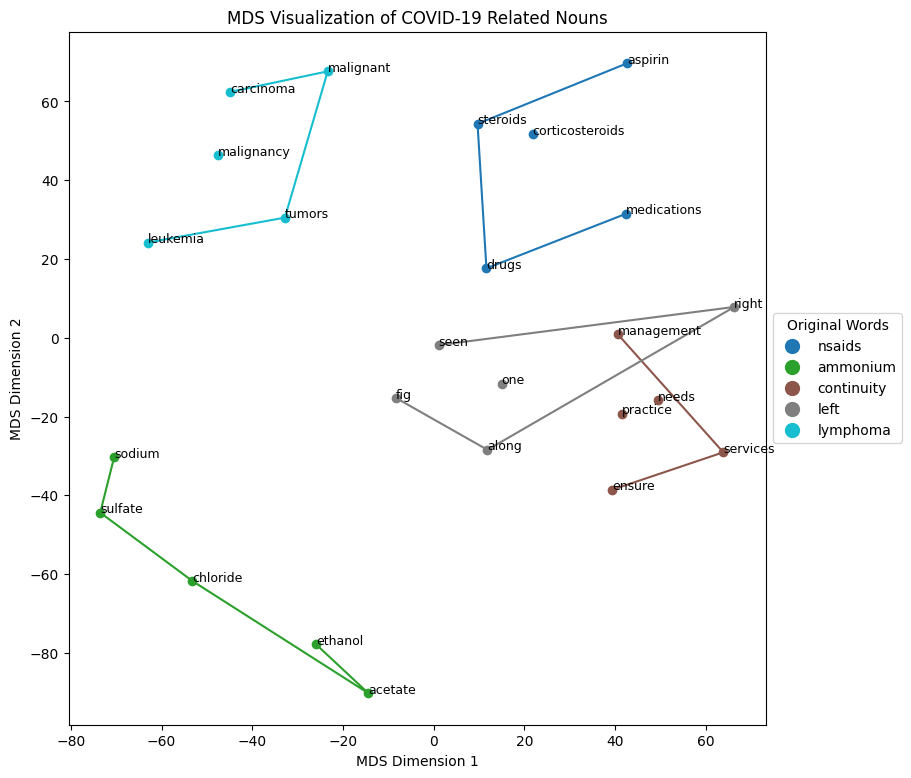

In [ ]:
def create_mds_plot(closest_words, title,prob_coocurrence_matrix= prob_cooccurrence_matrix,tok_idx=tok_idx):
    selected_words = []
    selected_keys = []
    for key, values in closest_words.items():
        selected_keys.append(key)
        selected_words.extend(values)

    selected_indices = [tok_idx[word] for word in selected_words if word in tok_idx]
    selected_embeddings = prob_coocurrence_matrix[selected_indices]

    # Perform MDS
    legend_entries = []
    mds = MDS(n_components=2, random_state=42)
    embeddings_2d = mds.fit_transform(selected_embeddings)

    # Create a color map for keys
    unique_keys = list(closest_words.keys())
    colors = plt.cm.get_cmap('tab10', len(unique_keys))  # Use a colormap

    plt.figure(figsize=(9, 9))

    for i, key in enumerate(unique_keys):
        word_indices = [selected_words.index(word) for word in closest_words[key]]
        word_embeddings = embeddings_2d[word_indices]
        for idx in word_indices:
            plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], color=colors(i))
            plt.text(embeddings_2d[idx, 0], embeddings_2d[idx, 1], selected_words[idx], fontsize=9)
        if len(word_embeddings) > 2:  # Need at least 3 points to form a hull
            hull = ConvexHull(word_embeddings)
            hull_points = word_embeddings[hull.vertices]
            plt.plot(hull_points[:, 0], hull_points[:, 1], color=colors(i), linestyle='-', lw=1.5)
        legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), label=f'{key}', markersize=12))

    plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title='Original Words')
    plt.title(title)
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.show()

create_mds_plot(closest_nouns, 'MDS Visualization of COVID-19 Related Nouns')


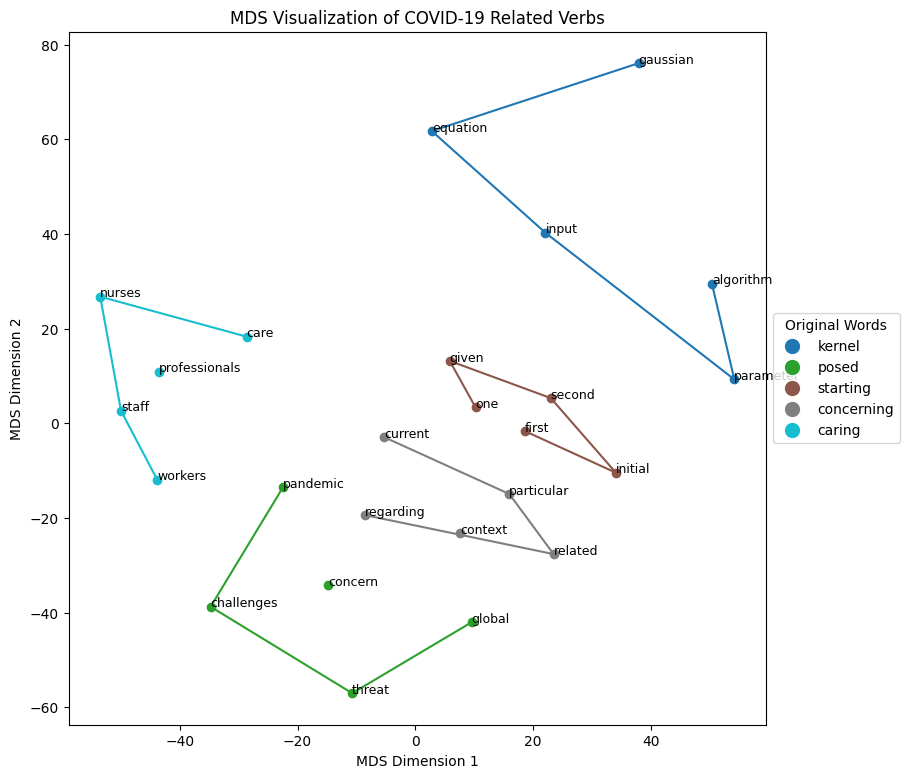

In [ ]:
create_mds_plot(closest_verbs, 'MDS Visualization of COVID-19 Related Verbs')